In [1]:
!pip install xgboost

  Using cached xgboost-1.5.1-py3-none-win_amd64.whl (106.6 MB)


In [2]:
''' Models Are Dependently Trained --> Sequential '''

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

import xgboost as xgb


In [4]:
### Load The Data
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [5]:
### Preprocessing

#print(df.status.value_counts())
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)


#print(df.describe().round().T)
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [6]:
## Split The Data
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, random_state=11)

y_train = (df_train.status == 'default').values ## 1: default, 0 otherwise
y_valid = (df_valid.status == 'default').values

del df_train['status']
del df_valid['status']

df_train_dict = df_train.fillna(0).to_dict(orient='records')
df_valid_dict = df_valid.fillna(0).to_dict(orient='records')

## 
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train_dict)
X_valid = dv.transform(df_valid_dict)


In [112]:
%%capture output

### Model
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names())
dvalid = xgb.DMatrix(X_valid, label=y_valid, feature_names=dv.get_feature_names())


xgb_params = {
    'eta': 0.05,                     ## Learning Rate
    'max_depth': 10,                  ## 
    'min_child_weight': 1,           ## Minimum Samples Leaf
    
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,                      ## 
    'verbosity':1,                  ## Display Warnings
    }
watchlist = [(dtrain, 'Train'), (dvalid, 'Validation')]

model = xgb.train(xgb_params, dtrain, 
                  evals=watchlist, 
                  num_boost_round=200)

In [113]:
print(output.stdout)

[0]	Train-auc:0.91502	Validation-auc:0.79790
[1]	Train-auc:0.92061	Validation-auc:0.80453
[2]	Train-auc:0.92468	Validation-auc:0.80720
[3]	Train-auc:0.92737	Validation-auc:0.80953
[4]	Train-auc:0.93602	Validation-auc:0.81749
[5]	Train-auc:0.94281	Validation-auc:0.82269
[6]	Train-auc:0.94703	Validation-auc:0.82498
[7]	Train-auc:0.94838	Validation-auc:0.82598
[8]	Train-auc:0.95037	Validation-auc:0.82736
[9]	Train-auc:0.95225	Validation-auc:0.82935
[10]	Train-auc:0.95592	Validation-auc:0.83237
[11]	Train-auc:0.95738	Validation-auc:0.83109
[12]	Train-auc:0.95987	Validation-auc:0.83330
[13]	Train-auc:0.96127	Validation-auc:0.83388
[14]	Train-auc:0.96211	Validation-auc:0.83478
[15]	Train-auc:0.96300	Validation-auc:0.83643
[16]	Train-auc:0.96504	Validation-auc:0.83678
[17]	Train-auc:0.96667	Validation-auc:0.83735
[18]	Train-auc:0.96868	Validation-auc:0.83639
[19]	Train-auc:0.96988	Validation-auc:0.83732
[20]	Train-auc:0.97120	Validation-auc:0.83700
[21]	Train-auc:0.97208	Validation-auc:0.8369

In [114]:
y_preds = model.predict(dvalid)
acc = roc_auc_score(y_valid, y_preds)
print('Accuracy:', (acc*100).round(2))

Accuracy: 84.16


In [115]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, valid_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        valid = float(valid_line.split(':')[1])
        
        results.append((it, train, valid))
        
    columns = ['num_iter', 'train_auc', 'valid_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [116]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,valid_auc
0,0,0.91502,0.79790
1,1,0.92061,0.80453
2,2,0.92468,0.80720
3,3,0.92737,0.80953
4,4,0.93602,0.81749
...,...,...,...
195,195,0.99998,0.84149
196,196,0.99999,0.84155
197,197,0.99999,0.84141
198,198,0.99999,0.84152


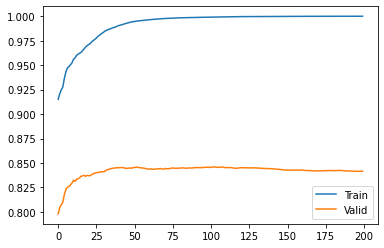

In [117]:
import matplotlib.pyplot as plt 

plt.plot(df_score.num_iter, df_score.train_auc, label='Train')
plt.plot(df_score.num_iter, df_score.valid_auc, label='Valid')
plt.legend()

In [118]:
key = 'eta=%s' % (xgb_params['eta'])

scores = {}
scores[key] = parse_xgb_output(output)

In [123]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.valid_auc, label=eta)
plt.legend()

KeyError: 'eta=1.0'